In [ ]:
"""
parameters:
    csv_data:
        mesa, shhs: 'ahi_a0h3'
        mros: 'poahi3'
    segment_2d = False
    segment_len = None
    signal_len = 6*60*60*100
    batch_size = 64
    epochs = 500
    optimizer = Adam(lr=1e-3)
    scheduler = None
"""

In [1]:
import json, tempfile
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from torchinfo import summary
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = Path(r'..\dataset\del_wake')
data_json = Path(r'..\dataset\data_list')
mesa_mros_shhs = 'data_class_20230130.json'
apnea_ecg = 'apnea_ecg_20230217.json'
private_data = '耕莘dataset_20230314.json'
train_name_lst = ['mesa', 'MrOS_visit1', 'MrOS_visit2', 'shhs2']

In [3]:
# MESA + MrOS + SHHS
with open(data_json/mesa_mros_shhs) as f:
    all_npz = json.load(f)
# Apnea-ECG
with open(data_json/apnea_ecg) as f:
    apnea_npz = json.load(f)
for k in apnea_npz.keys():
    all_npz[f'apnea_ecg_{k}'] = apnea_npz[k]
# 耕莘 dataset
with open(data_json/private_data, encoding='utf-8') as f:
    all_npz['耕莘dataset'] = json.load(f)

data_num = [[len(i) for i in v.values()] for v in all_npz.values()]
df = pd.DataFrame(data_num).transpose()
df.index = ['normal', 'mild', 'moderate', 'severe']
df.columns = [k for k in all_npz.keys()]
df.loc['total'] = df.sum(axis=0)
df.loc[:, 'total'] = df.sum(axis=1)
df

,mesa,MrOS_visit1,MrOS_visit2,shhs1,shhs2,apnea_ecg_train,apnea_ecg_test,耕莘dataset,total
normal,365,896,265,1623,608,11,12,45,3825
mild,586,1879,614,1848,925,3,2,77,5934
moderate,462,1430,492,1132,610,7,4,61,4198
severe,421,1024,400,697,404,14,17,162,3139
total,1834,5229,1771,5300,2547,35,35,345,17096


In [4]:
train_list = []
test_list = {k: [] for k in all_npz.keys() if k not in train_name_lst}

for k, v in all_npz.items():
    if k in train_name_lst:
        for i in v.values():
            train_list += i
    else:
        for j in v.values():
            test_list[k] += j

print(f'train list: \n\t{len(train_list)}')
print('test list:')
for k, v in test_list.items():
    print(f'\t{k}: {len(v)}')

train list: 
	11381
test list:
	shhs1: 5300
	apnea_ecg_train: 35
	apnea_ecg_test: 35
	耕莘dataset: 345


In [5]:
SR = 100 # sample rate
segment_2d = False # segment signal to 2D
segment_len = 60*SR if segment_2d else None # length of each segment
signal_len = 6*60 if segment_2d else 6*60*60*SR # length of signal

def z_score(signal):
    return (signal-signal.mean())/signal.std()

def AHI_class(AHI):
    if AHI < 5:
        label = 0
    elif 5 <= AHI < 15:
        label = 1
    elif 15 <= AHI < 30:
        label = 2
    else: label = 3
        
    return label

def read_npz_file(file):
    npz_data = np.load(file, allow_pickle=True)
    signal = z_score(npz_data['ECG'])
    
    if segment_2d:
        segment_num = len(signal)//segment_len
        signal = signal[:segment_num*segment_len].reshape((segment_num, segment_len))
            
    if 'mros' in file:
        label = AHI_class(float(npz_data['csv_data'].item()['poahi3']))
    elif 'apnea-ecg-database' in file or '耕莘' in file:
        label = AHI_class(npz_data['AHI'])
    else:
        label = AHI_class(float(npz_data['csv_data'].item()['ahi_a0h3']))
        
    return signal, label

def cut_pad_signal(signal, length=signal_len, mode='middle'):
    if len(signal) > length:
        cut_len = len(signal)-length
        if mode == 'middle': # cut from middle
            mid = cut_len//2
            return signal[mid:mid+length]
        elif mode == 'random': # random cut
            rand = np.random.randint(cut_len)
            return signal[rand:rand+length]
    else:
        pad_len = length-len(signal)
        if segment_2d:
            signal = np.pad(signal, ((0, pad_len), (0, 0)))
        else:
            signal = np.pad(signal, (0, pad_len))
        return signal

In [6]:
train_info = {i: [] for i in ['signal', 'label']}
test_info = {j: {i: [] for i in ['signal', 'label']} for j in test_list.keys()}

for file in tqdm(train_list):
    path = data_dir/file
    signal, label = read_npz_file(str(path))
    train_info['signal'].append(signal)
    train_info['label'].append(label)

for k, v in test_list.items():
    for file in tqdm(v):
        path = data_dir/file
        signal, label = read_npz_file(str(path))
        test_info[k]['signal'].append(signal)
        test_info[k]['label'].append(label)

100%|████████████████████████████████████████████████████████████████████████████████| 345/345 [00:19<00:00, 17.60it/s]


In [7]:
# set model name
time_stamp = datetime.now().strftime('_%Y%m%d_%H%M%S')
model_name = 'm011'+time_stamp

In [7]:
# for reload model
model_name = 'm011_20230428_174643'

In [8]:
from models import m011
model = m011().cuda()
print(model_name)

logs_tb_dir = Path('logs_tb', model_name)
logs_tb_dir.mkdir(parents=True, exist_ok=True)
logs_json_dir = Path('logs_json', model_name)
logs_json_dir.mkdir(parents=True, exist_ok=True)
weights_dir = Path('weights', model_name)
weights_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path('results', model_name)
results_dir.mkdir(parents=True, exist_ok=True)

m011_20230428_174643


In [9]:
class TrainingDataset(Dataset):
    def __init__(self, data_type, signal, label):
        self.data_type = data_type
        self.signal = signal
        self.label = label
        
    def __getitem__(self, index):
        if self.data_type == 'train':
            signal = cut_pad_signal(self.signal[index], mode='random') # fixed length, random cut
            signal = -signal if np.random.rand() < .5 else signal # 隨機振幅反轉
        elif self.data_type == 'test':
            signal = cut_pad_signal(self.signal[index]) # fixed length
            
        signal = torch.tensor(signal, dtype=torch.float32).cuda().unsqueeze(0) # [channel, row]
        label = torch.tensor(self.label[index], dtype=torch.int64).cuda()
        return signal, label
    
    def __len__(self):
        return len(self.signal)

In [10]:
batch_size = 64
train_data = DataLoader(TrainingDataset('train', train_info['signal'], train_info['label']),
                        batch_size=batch_size, shuffle=True, drop_last=True)
test_data = DataLoader(TrainingDataset('test', test_info['shhs1']['signal'], test_info['shhs1']['label']),
                       batch_size=batch_size)

In [11]:
# show model summary
model_input, _ = train_data.dataset[0]
summary(model, model_input.unsqueeze(0).size())

Layer (type:depth-idx)                                  Output Shape              Param #
Model                                                   [1, 4]                    --
├─MultiPath: 1-1                                        [1, 64, 21599]            --
│    └─Sequential: 2-1                                  [1, 48, 21599]            --
│    │    └─Sequential: 3-1                             [1, 48, 215999]           1,008
│    │    └─Sequential: 3-2                             [1, 48, 21599]            43,872
│    └─Sequential: 2-2                                  [1, 32, 21599]            --
│    │    └─Sequential: 3-3                             [1, 32, 431999]           352
│    │    └─Sequential: 3-4                             [1, 32, 86399]            9,280
│    │    └─Sequential: 3-5                             [1, 32, 21599]            7,232
│    └─Sequential: 2-3                                  [1, 64, 21599]            --
│    │    └─Conv1d: 3-6                       

In [12]:
# draw model graph
writer = SummaryWriter(logs_tb_dir, filename_suffix='-model_graph.tb')
model_input, _ = train_data.dataset[0]
writer.add_graph(model, model_input.unsqueeze(0))
writer.close()

In [13]:
def start_training(epochs, optimizer, scheduler=None, st_epoch=1, save_step=100, best_loss=10., best_acc=0.):
    logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []} # for json logs
    writer = SummaryWriter(logs_tb_dir, filename_suffix='-training_logs.tb') # for tb logs
    fn_epoch = st_epoch+epochs-1 # final epoch
    len_fn_epoch = len(str(fn_epoch)) # length of final epoch text
    pbar_colors = {'train': 'yellow', 'test': 'green'} # colors of progress bar
    criterion = nn.CrossEntropyLoss() # for CE loss calculation
    
    for e in range(epochs):
        cr_epoch = st_epoch+e # current epoch
        for p, phase in enumerate(['train', 'test']):
            data_num, running_loss, running_acc = 0, 0., 0.
            
            if p == 0:
                model.train() # training mode
                batch_data = train_data
            elif p == 1:
                model.eval() # evaluation mode
                batch_data = test_data

            pbar = tqdm(batch_data, unit='batch', # custom progress bar
                        desc=f'{cr_epoch:0>{len_fn_epoch}}/{fn_epoch} - {phase:>5}: ', colour=pbar_colors[phase])
            
            for b, batch in enumerate(pbar):
                signals, labels = batch
                data_num += signals.size(0)
                
                if p == 0:
                    optimizer.zero_grad() # clear gradients of optimizer
                    outputs = model(signals) # forward
                    loss = criterion(outputs, labels) # calculate loss
                    _, preds = torch.max(outputs.data, 1) # get predicted results
                    loss.backward() # calculate gradients
                    optimizer.step() # update weights
                    
                elif p == 1:
                    with torch.no_grad(): # don't calculate gradients in test
                        outputs = model(signals)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                
                running_loss += loss.item()*signals.size(0)
                running_acc += torch.sum(preds == labels).item()
                
                if b == len(pbar)-1:
                    current_loss = running_loss/data_num # calculate current loss
                    current_acc = running_acc/data_num # calculate current accuracy
                    pbar.set_postfix_str(f'loss: {current_loss:.4f}, acc: {current_acc:.4f}')
            
            if p == 0:
                record_phase = 'Training'

                weights = model.state_dict()
                torch.save(weights, weights_dir/'last.pth') # save last weights
                if cr_epoch%save_step == 0: # save weights when reached step
                    torch.save(weights, weights_dir/f'epoch_{cr_epoch}.pth')
                    
            elif p == 1:
                record_phase = 'Testing'

                if current_loss < best_loss:
                    best_loss = current_loss
                    torch.save(weights, weights_dir/'best_loss.pth') # save lowest loss weights
                if current_acc > best_acc:
                    best_acc = current_acc
                    torch.save(weights, weights_dir/'best_acc.pth') # save highest accuracy weights
            
            # save training logs
            writer.add_scalar(f'Loss/{record_phase}', current_loss, cr_epoch)
            writer.add_scalar(f'Accuracy/{record_phase}', current_acc, cr_epoch)    
            logs[f'{phase}_loss'].append(current_loss)
            logs[f'{phase}_acc'].append(current_acc)
            with open(logs_json_dir/f'epoch_{st_epoch}-{fn_epoch}.json', 'w') as f:
                json.dump(logs, f)
 
        if scheduler:
            scheduler.step() # update scheduler
    
    writer.close()
    print(f"{' Training finished. ':=^80}")
    print(f"{f' best loss: {best_loss:.4f}, best acc: {best_acc:.4f} ':-^80}")
    
    return logs

In [14]:
# training from begining
epochs = 500
optimizer = optim.Adam(model.parameters(), 1e-3)

logs = start_training(epochs, optimizer)

500/500 -  test: 100%|███████████████████████████████████| 83/83 [00:27<00:00,  2.97batch/s, loss: 2.3213, acc: 0.5332]

============================== Training finished. ==============================
--------------------- best loss: 0.9124, best acc: 0.5915 ----------------------


In [ ]:
# training from trained weights
trained_epoch = max([int(f.stem.split('_')[1]) for f in weights_dir.glob('epoch_*.pth')]) # final epoch
model.load_state_dict(torch.load(weights_dir/f'epoch_{trained_epoch}.pth')) # trained weights

epochs = 200
optimizer = optim.Adam(model.parameters(), 1e-3)

# best_loss 和 best_acc 從上方儲存格最後的輸出取得
logs = start_training(epochs, optimizer, st_epoch=trained_epoch+1, best_loss=0.9124 best_acc=0.5915

In [15]:
def show_training_log(logs, epochs, st_epoch=1):
    plt.figure(figsize=(10, 5))
    for p, phase in enumerate(['loss', 'acc']):
        plt.subplot(1, 2, p+1)
        plt.plot(range(st_epoch, st_epoch+epochs), logs['train_'+phase])
        plt.plot(range(st_epoch, st_epoch+epochs), logs['test_'+phase])
        
        plt.xlabel('Epoch')
        if p == 0:
            plt.ylabel('Loss')
        elif p == 1:
            plt.ylabel('Accuracy')
        plt.legend(['Training','Testing'], loc='upper left')
        
    plt.tight_layout()
    plt.show()

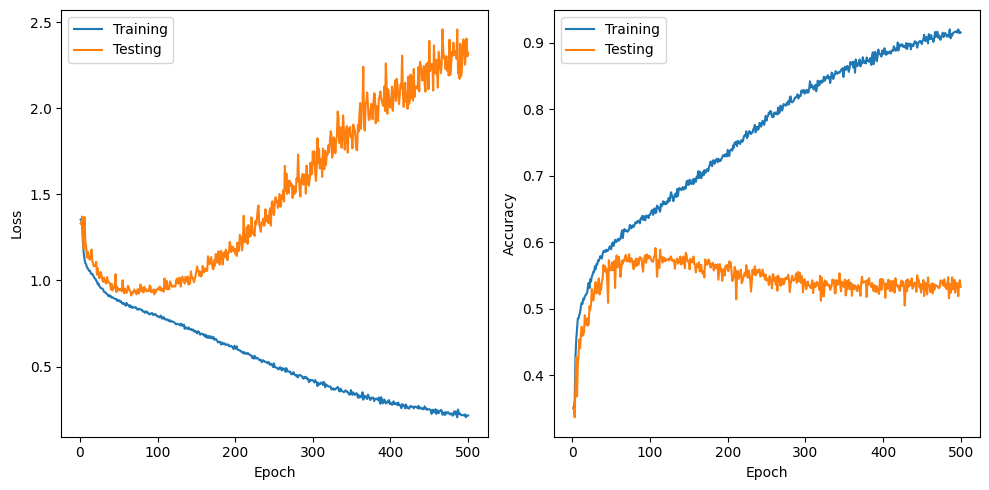

In [16]:
show_training_log(logs, epochs)

In [ ]:
show_training_log(logs, epochs, trained_epoch+1)

In [9]:
def start_evaluate():
    model.eval()
    results = {}
    num_errors = {}
    
    for p, phase in enumerate(['train', 'test1', 'test2', 'test3', 'test4']):
        data_num, running_acc = 0, 0.
        all_labels, all_preds = [], []
        num_errors[phase] = 0

        if p == 0:
            batch_data = train_data
        elif p == 1:
            batch_data = test_data['shhs1']
        elif p == 2:
            batch_data = test_data['apnea_ecg_train']
        elif p == 3:
            batch_data = test_data['apnea_ecg_test']
        elif p == 4:
            batch_data = test_data['耕莘dataset']

        pbar = tqdm(batch_data, unit='batch', desc=f'{phase:>5}: ')
        for b, batch in enumerate(pbar):
            signals, labels = batch
            data_num += signals.size(0)
            
            try:
                with torch.no_grad():
                    outputs = model(signals)
                    _, preds = torch.max(outputs, 1)

                running_acc += torch.sum(preds == labels).item()
                
                all_labels += labels.tolist()
                all_preds += preds.tolist()
                
            except RuntimeError: # sizes of tensors must match except in dimension 1 (error occured in concat)
                num_errors[phase] += 1
                
            if b == len(pbar)-1:
                current_acc = running_acc/data_num
                pbar.set_postfix_str(f'acc: {current_acc:.4f}')

        results[phase] = {'labels': all_labels, 'preds': all_preds}

    return results, num_errors

In [10]:
def calc_score(cm):
    scores = []
    total_TP = 0
    cls_num = cm.shape[0]
    all_num = np.sum(cm)
    
    for i in range(cls_num):
        TP = cm[i, i]
        FP = np.sum(cm[:, i])-TP
        FN = np.sum(cm[i, :])-TP
        TN = all_num-FN-FP-TP
        
        pre = TP/(TP+FP) if TP != 0 else 0 # precision
        sen = TP/(TP+FN) if TP != 0 else 0 # sensitivity
        spe = TN/(TN+FP) if TN != 0 else 0 # specificity
        F1 = 2*(pre*sen)/(pre+sen) if pre+sen != 0 else 0 # F1-score
        scores.append({'pre': pre, 'sen': sen, 'spe': spe, 'F1': F1})
        
        total_TP += TP
    acc = total_TP/all_num # accuracy
    
    return scores, acc

def show_confusion_matrix(result_type, phase, labels, preds):
    fig = plt.figure(figsize=(5, 5))
    if phase == 'train':
        record_phase = 'Training (MESA, MrOS, SHHS2)'
    elif phase == 'test1':
        record_phase = 'Testing (SHHS1)'
    elif phase == 'test2':
        record_phase = 'Testing (Apnea-ECG_Training)'
    elif phase == 'test3':
        record_phase = 'Testing (Apnea-ECG_Testing)'
    elif phase == 'test4':
        record_phase = 'Testing (耕莘dataset)'
    print(f'{record_phase}:')
    
    cm = confusion_matrix(labels, preds)
    scores, acc = calc_score(cm)
    
    fontsize = 18
    font = {'family': 'Times New Roman', 'size': fontsize}
    plt.rc('font', **font)
    ax = sn.heatmap(cm, annot=True, annot_kws={'size': fontsize}, cmap='Blues', cbar=False, fmt='',
                    linewidths=.5, linecolor='black', clip_on=False)
    ax.set_ylabel('Label', fontweight='bold', fontsize=fontsize)
    ax.set_title('Predicted', fontweight='bold', fontsize=fontsize)
    ax.xaxis.tick_top()
    
    print(f'Accuracy: {acc*100:.2f}%')
    print(f"{'Class'}{'Precision':>11}{'Sensitivity':>13}{'Specificity':>13}{'F1-score':>10}")
    for i in range(len(scores)):
        cls_scores = scores[i]
        print(f"{i:>5}{cls_scores['pre']:>11.4f}{cls_scores['sen']:>13.4f}"+
              f"{cls_scores['spe']:>13.4f}{cls_scores['F1']:>10.4f}")
    
    plt.tight_layout()
    plt.show()
    writer.add_figure(f'Confusion Matrix ({result_type})/{record_phase}', fig)

In [11]:
class EvaluationDataset(Dataset):
    def __init__(self, data_type, signal, label):
        self.data_type = data_type
        self.signal = signal
        self.label = label
        
    def __getitem__(self, index):
        if self.data_type == 'fixed': # fixed length
            signal = torch.tensor(cut_pad_signal(self.signal[index]), dtype=torch.float32).cuda().unsqueeze(0)
        elif self.data_type == 'original': # original length
            signal = torch.tensor(self.signal[index], dtype=torch.float32).cuda().unsqueeze(0)
        label = torch.tensor(self.label[index], dtype=torch.int64).cuda()
        return signal, label
    
    def __len__(self):
        return len(self.signal)

In [12]:
# fixed length results
batch_size = 64
train_data = DataLoader(EvaluationDataset('fixed', train_info['signal'], train_info['label']),
                        batch_size=batch_size)
test_data = {}
for k in test_list.keys():
    test_data[k] = DataLoader(EvaluationDataset('fixed', test_info[k]['signal'], test_info[k]['label']),
                              batch_size=batch_size)

In [13]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname], num_errors = start_evaluate()
print(num_errors)

with open(results_dir/'fixed_length.json', 'w') as f:
     json.dump(results, f)

best_acc:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.45batch/s, acc: 0.4957]


best_loss:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.44batch/s, acc: 0.4580]


epoch_100:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.51batch/s, acc: 0.5217]


epoch_200:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.56batch/s, acc: 0.4783]


epoch_300:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.37batch/s, acc: 0.4696]


epoch_400:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.52batch/s, acc: 0.4783]


epoch_500:


test4: 100%|█████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.47batch/s, acc: 0.4580]


{'train': 0, 'test1': 0, 'test2': 0, 'test3': 0, 'test4': 0}


In [24]:
# for reload results
with open(results_dir/'fixed_length.json', 'r') as f:
     results = json.load(f)

Training (MESA, MrOS, SHHS2):
Accuracy: 66.99%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6778       0.6396       0.9298    0.6581
    1     0.6252       0.7075       0.7698    0.6639
    2     0.6302       0.5625       0.8822    0.5944
    3     0.8050       0.7746       0.9538    0.7895


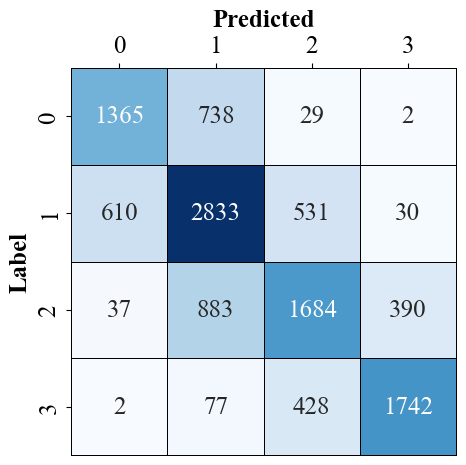

Testing (SHHS1):
Accuracy: 59.15%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6467       0.6778       0.8366    0.6619
    1     0.5178       0.5833       0.7092    0.5486
    2     0.5573       0.4594       0.9009    0.5036
    3     0.7483       0.6270       0.9681    0.6823


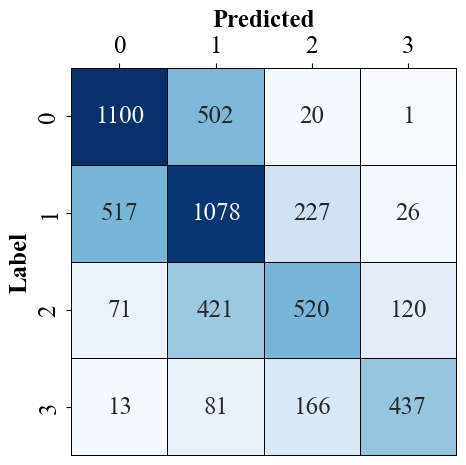

Testing (Apnea-ECG_Training):
Accuracy: 42.86%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.0000       0.0000       1.0000    0.0000
    1     0.0000       0.0000       0.6562    0.0000
    2     0.5000       0.2857       0.9286    0.3636
    3     0.6500       0.9286       0.6667    0.7647


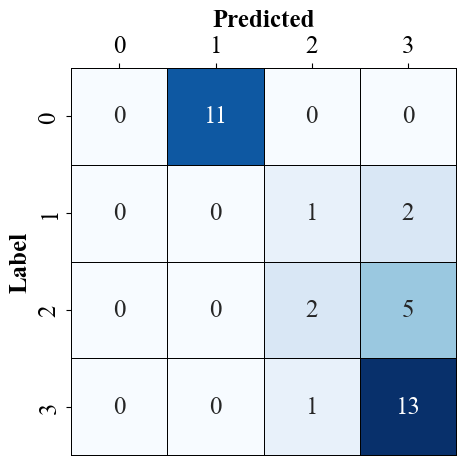

Testing (Apnea-ECG_Testing):
Accuracy: 65.71%
Class  Precision  Sensitivity  Specificity  F1-score
    0     1.0000       0.1667       1.0000    0.2857
    1     0.1000       0.5000       0.7273    0.1667
    2     0.7500       0.7500       0.9677    0.7500
    3     0.8947       1.0000       0.8889    0.9444


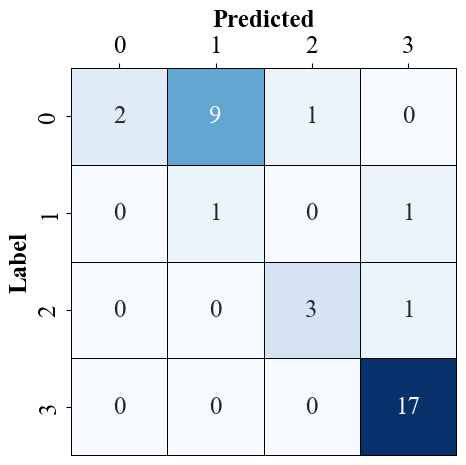

Testing (耕莘dataset):
Accuracy: 49.57%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.5789       0.2444       0.9733    0.3438
    1     0.3487       0.6883       0.6306    0.4629
    2     0.2597       0.3279       0.7993    0.2899
    3     0.8969       0.5370       0.9454    0.6718


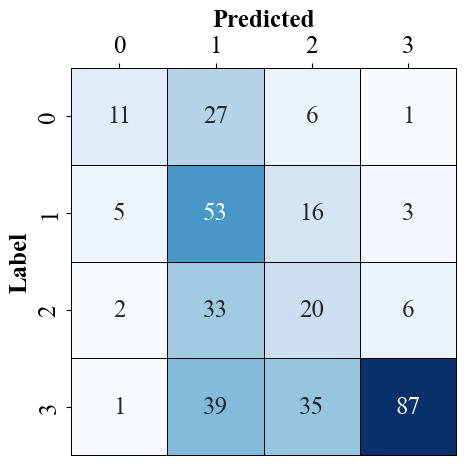

In [14]:
writer = SummaryWriter(logs_tb_dir, filename_suffix='-CM_fixed_len.tb')
chosen_result = results['best_acc']
for k, v in chosen_result.items():
    show_confusion_matrix('Fixed Length', k, v['labels'], v['preds'])
writer.close()

In [17]:
# original length results
batch_size = 1
train_data = DataLoader(EvaluationDataset('original', train_info['signal'], train_info['label']),
                        batch_size=batch_size)
test_data = {}
for k in test_list.keys():
    test_data[k] = DataLoader(EvaluationDataset('original', test_info[k]['signal'], test_info[k]['label']),
                              batch_size=batch_size)

In [18]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname], num_errors = start_evaluate()
print(num_errors)

with open(results_dir/'original_length.json', 'w') as f:
     json.dump(results, f)

best_acc:


test4: 100%|█████████████████████████████████████████████████████████| 345/345 [00:04<00:00, 72.30batch/s, acc: 0.4783]


best_loss:


test4: 100%|████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 100.30batch/s, acc: 0.4522]


epoch_100:


test4: 100%|█████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 99.80batch/s, acc: 0.5362]


epoch_200:


test4: 100%|█████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 98.35batch/s, acc: 0.4725]


epoch_300:


test4: 100%|█████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 96.52batch/s, acc: 0.4667]


epoch_400:


test4: 100%|█████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 98.31batch/s, acc: 0.4899]


epoch_500:


test4: 100%|█████████████████████████████████████████████████████████| 345/345 [00:03<00:00, 97.74batch/s, acc: 0.4841]


{'train': 0, 'test1': 0, 'test2': 0, 'test3': 0, 'test4': 0}


In [26]:
# for reload results
with open(results_dir/'original_length.json', 'r') as f:
     results = json.load(f)

Training (MESA, MrOS, SHHS2):
Accuracy: 67.80%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6915       0.6345       0.9347    0.6618
    1     0.6293       0.7195       0.7700    0.6714
    2     0.6408       0.5808       0.8837    0.6093
    3     0.8175       0.7746       0.9574    0.7954


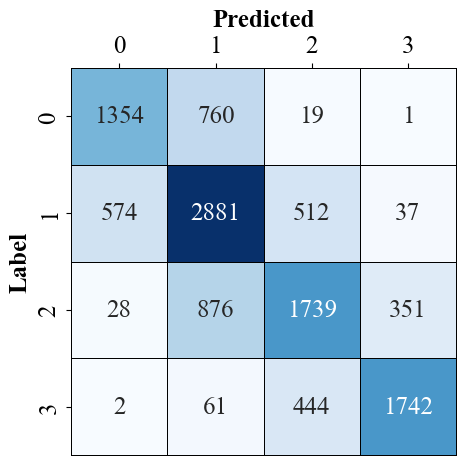

Testing (SHHS1):
Accuracy: 59.49%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6556       0.6790       0.8425    0.6671
    1     0.5210       0.5974       0.7060    0.5566
    2     0.5469       0.4532       0.8980    0.4957
    3     0.7722       0.6227       0.9722    0.6894


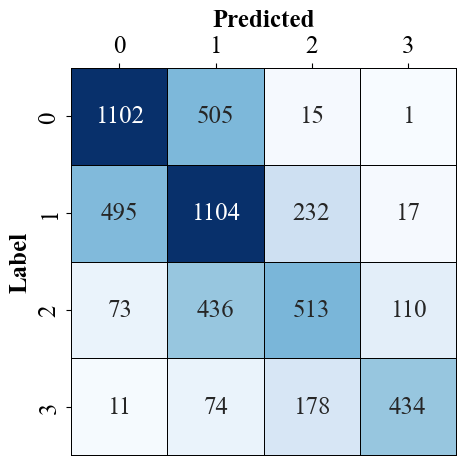

Testing (Apnea-ECG_Training):
Accuracy: 40.00%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.0000       0.0000       1.0000    0.0000
    1     0.0000       0.0000       0.6562    0.0000
    2     0.2500       0.1429       0.8929    0.1818
    3     0.6500       0.9286       0.6667    0.7647


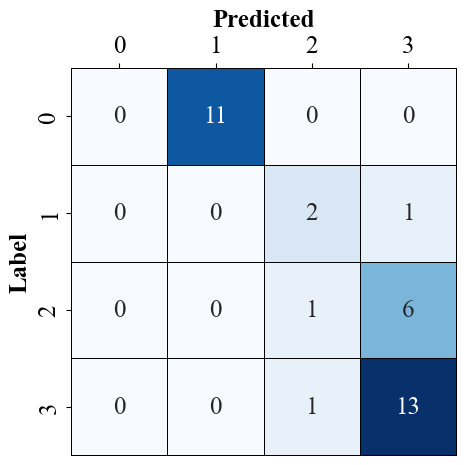

Testing (Apnea-ECG_Testing):
Accuracy: 62.86%
Class  Precision  Sensitivity  Specificity  F1-score
    0     1.0000       0.1667       1.0000    0.2857
    1     0.0000       0.0000       0.7273    0.0000
    2     0.6000       0.7500       0.9355    0.6667
    3     0.8947       1.0000       0.8889    0.9444


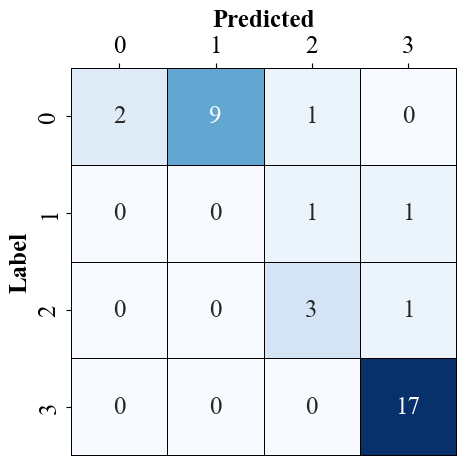

Testing (耕莘dataset):
Accuracy: 47.83%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6250       0.2222       0.9800    0.3279
    1     0.3375       0.7013       0.6045    0.4557
    2     0.2400       0.2951       0.7993    0.2647
    3     0.8830       0.5123       0.9399    0.6484


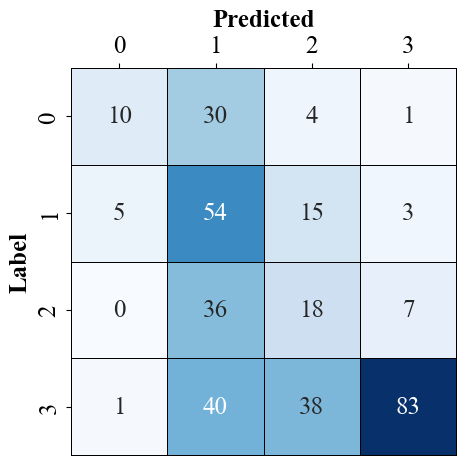

In [19]:
writer = SummaryWriter(logs_tb_dir, filename_suffix='-CM_original_len.tb')
chosen_result = results['best_acc']
for k, v in chosen_result.items():
    show_confusion_matrix('Original Length', k, v['labels'], v['preds'])
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs_tb --reload_multifile True

tb_temp_dir = Path(tempfile.gettempdir(), '.tensorboard-info')
for tb_temp in tb_temp_dir.glob('*.info'):
    tb_temp.unlink(missing_ok=True)